In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from numpy import array
from datetime import datetime
import seaborn as sns

2022-10-06 22:33:11.363253: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-06 22:33:11.363298: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Replace missing values with Zero and Group by month

In [3]:
df = pd.read_csv('consumos_abo.csv', parse_dates=['date'])
df = df.set_index('date')
df = df.groupby('abo').resample('M').sum()

### Create batches of training data (12 months)

In [4]:
def split_sequence(sequence, sequence_total, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence_total[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit MLP model 

In [5]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=50)
    model = Sequential()
    model.add(Dense(800, activation='relu', input_shape=(n_steps_in,)))
    model.add(Dense(800, activation='relu', 
                kernel_regularizer=regularizers.l1_l2(l1=1e-3, l2=1e-3),
                bias_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=500, verbose=1, callbacks=[callback])
    return model 

In [6]:
def train_predict(dataset, dataset_total, test, actual):
    n_steps_in, n_steps_out, slide = 6, 2, 1
    X, y = split_sequence(dataset, dataset_total, n_steps_in, n_steps_out, slide)
    
    # flatten input and output
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    n_output = y.shape[1] * y.shape[2]
    y = y.reshape((y.shape[0], n_output))

    model = fit(X, y, n_input, n_output)      
    
    mae, rmse, smape = list(), list(), list()
    for i in range(0, len(test)-n_steps_in, n_steps_out):
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_input, 1))
        pred = model.predict(x_input)
        mae_aux, rmse_aux, smape_aux = measure_error(actual, pred[0], n_steps_in, n_steps_out, i)
        mae.append(mae_aux), rmse.append(rmse_aux), smape.append(smape_aux)
    
    return mae, rmse, smape

In [7]:
def sMAPE(actual, predicted):
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [8]:
def measure_error(actual, pred, step_in, step_out, index):
    #print(actual[index+step_in:index+step_in+step_out],pred,index+step_in,index+step_in+step_out)
    #print(len(actual[index+step_in:index+step_in+step_out]),len(pred))
    mae = mean_absolute_error(actual[index+step_in:index+step_in+step_out], pred)
    rmse = np.sqrt(mean_squared_error(actual[index+step_in:index+step_in+step_out], pred))
    smape = sMAPE(actual[index+step_in:index+step_in+step_out], pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

In [9]:
df1 = df.pivot_table('nr', 'date', 'abo')
df1['Total'] = df1.sum(axis=1)

In [10]:
dataset = df1[['A', 'AB', 'B', 'O']].values
dataset_total = df1[['Total']].values
mae, rmse, smape = train_predict(dataset[:216], dataset_total[:216], dataset[216:], df1[['Total']][216:].values)

Epoch 1/500


2022-10-06 22:33:19.129251: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-06 22:33:19.129280: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-06 22:33:19.129304: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-06 22:33:19.129743: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


7/7 [==============================] - 1s 15ms/step - loss: 107349496.0000
Epoch 2/500
7/7 [==============================] - 0s 10ms/step - loss: 15952491.0000
Epoch 3/500
7/7 [==============================] - 0s 10ms/step - loss: 10213067.0000
Epoch 4/500
7/7 [==============================] - 0s 11ms/step - loss: 6422296.0000
Epoch 5/500
7/7 [==============================] - 0s 12ms/step - loss: 3209928.0000
Epoch 6/500
7/7 [==============================] - 0s 11ms/step - loss: 2629833.5000
Epoch 7/500
7/7 [==============================] - 0s 9ms/step - loss: 2419988.2500
Epoch 8/500
7/7 [==============================] - 0s 11ms/step - loss: 2318845.0000
Epoch 9/500
7/7 [==============================] - 0s 15ms/step - loss: 2557145.0000
Epoch 10/500
7/7 [==============================] - 0s 10ms/step - loss: 2532335.5000
Epoch 11/500
7/7 [==============================] - 0s 10ms/step - loss: 2422621.0000
Epoch 12/500
7/7 [==============================] - 0s 10ms/step - loss:

7/7 [==============================] - 0s 13ms/step - loss: 2108640.5000
Epoch 97/500
7/7 [==============================] - 0s 11ms/step - loss: 1898732.0000
Epoch 98/500
7/7 [==============================] - 0s 9ms/step - loss: 2044463.6250
Epoch 99/500
7/7 [==============================] - 0s 9ms/step - loss: 1834183.3750
Epoch 100/500
7/7 [==============================] - 0s 11ms/step - loss: 1807075.0000
Epoch 101/500
7/7 [==============================] - 0s 9ms/step - loss: 1762945.5000
Epoch 102/500
7/7 [==============================] - 0s 9ms/step - loss: 1843602.2500
Epoch 103/500
7/7 [==============================] - 0s 10ms/step - loss: 1811898.6250
Epoch 104/500
7/7 [==============================] - 0s 9ms/step - loss: 1995189.0000
Epoch 105/500
7/7 [==============================] - 0s 9ms/step - loss: 1905845.1250
Epoch 106/500
7/7 [==============================] - 0s 9ms/step - loss: 1773696.0000
Epoch 107/500
7/7 [==============================] - 0s 9ms/step - 

### Calculate Error

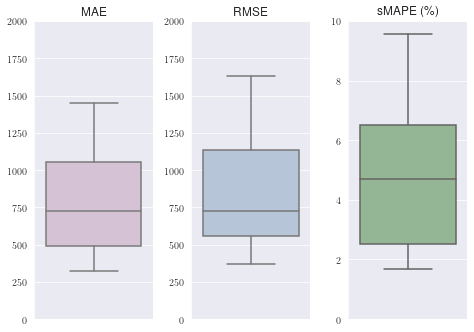

In [11]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(17*cm,12*cm))
sns.boxplot(ax=axes[0], y=mae, color='thistle', showfliers=False)
axes[0].set_title('MAE')
axes[0].set(ylim=(0, 2000))
sns.boxplot(ax=axes[1], y=rmse, color='lightsteelblue', showfliers=False)
axes[1].set_title('RMSE')
axes[1].set(ylim=(0, 2000))
sns.boxplot(ax=axes[2], y=smape, color='darkseagreen', showfliers=False)
axes[2].set_title('sMAPE (\%)')
axes[2].set(ylim=(0, 10))
plt.tight_layout()
plt.savefig('figures/demand_mlp_monthly_abo_boxplot.pdf')

In [12]:
demand_mlp_month_abo = [mae,rmse,smape]
%store demand_mlp_month_abo 

Stored 'demand_mlp_month_abo' (list)
